# Google Trends with pytrends - Walthrough and Sample Analysis

**Author:** Dylan Connor  
**Last Modified:** 7/11/2018

## Notes

Google trends is a free website that provides data for comparing looking at various search terms' popularity over time, or comparing search terms by geography. Search history can go back as far as 2004, and geography data can be broken by country, subregion (state in the US), metro (DMA in the US) and city.  Google trends can compare up to 5 search terms at once.

Google trends provides no actual search volumes. Instead it indexes all searches into a 0-100 scale. For interest over time, it will benchmark the highest search/search date combination as 100. All other search terms/dates will be normalized against that appropraitely. For searches by geography, the total seach popularity is normalized by total searches in that region, then allocated to the search terms proportionally.

This notebook details most of the available functionality of the open source pytrends API, a non-official API for pulling Google trends data with Python. It starts with general look at the functions and a discussion of the strengths and limitations of each, followed by example EDA and forecasting use cases. Functionality can be further explored in the pytrends readme or supporting documentation.

Note that Google Trends does have download limitations. Though it is not publicly disclosed, users have reported 1,400 sequential requests within 4 hours will trigger limits. 60 seconds of sleep will allow for bypassing limitations after they have been hit. 

## Key Sources

Python API:
https://github.com/GeneralMills/pytrends#interest-by-region

Google Trend Categories:
https://github.com/pat310/google-trends-api/wiki/Google-Trends-Categories

Google Trends: https://trends.google.com/trends/?geo=US

## Imports

In [1]:
from pytrends.request import TrendReq
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib
from fbprophet import Prophet #Only required for time series analyses at end
from IPython.display import Image

matplotlib.style.use('ggplot')
matplotlib.rcParams.update({'font.size': 12})

import warnings
warnings.filterwarnings(action='ignore')

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)



## Login

In [2]:
# Login once for an entire session
pytrend = TrendReq()

## Search Terms and Topics

In google trends, searches can either be simple search terms or topics. Search terms themsleves will provide results for the search term itself and related terms. Alternatively, Google buckets many search terms into Topics. These Topics help unify search terms across languages and filter possibly search terms with similar name but different meaning. For example, a search term of "NIKE" may pull in search terms for the Goddess. However, the topic would try to filter that out while casting a broader net towards searches referring to Nike the company. With unambiguous search terms, results are often similar. However, results can signficantly vary with some terms.

There is not much transparency into the Topics. See comments at: https://www.en.advertisercommunity.com/t5/Basics-for-New-Advertisers/Google-Trends-Topic-vs-Search-Term/td-p/735086

On the website, search terms are identified with simple text, where Topics are identified with codes such as %2Fm%2F0lwkh. The URL for the nike search term and Nike Topic is: https://trends.google.com/trends/explore?geo=US&q=nike,%2Fm%2F0lwkh

### suggestions()

With the pytrends engine, simply passing a term will default to a search term. If the user wants to get the topic, he/she can use the suggestions(keyword = ) function. This is akin to looking at the drop down box provided by google trends when typing in a search term. It returns a list of dictionaries, each with a "mid", "title", "type". Title being a topic title, 'type' being a descripter that indicates what this topic is related to, and finally, 'mid' is the code that needs to be used to search that topic. The suggestions will be in order of popularity, so taking the first in the list will often be the topic of interest.

In [20]:
print(pytrend.suggestions(keyword='Nintendo'), '\n')
print(pytrend.suggestions(keyword='Xbox'), '\n')
print(pytrend.suggestions(keyword='Playstation'), '\n')
print(pytrend.suggestions(keyword='Steam'), '\n')

[{'mid': '/m/059wk', 'title': 'Nintendo', 'type': 'Consumer electronics company'}, {'mid': '/m/0130pygf', 'title': 'Nintendo Switch', 'type': 'Video game console'}, {'mid': '/m/0bmjxs9', 'title': 'Nintendo 3DS', 'type': 'Game console'}, {'mid': '/m/028jm0', 'title': 'Nintendo DS', 'type': 'Game console'}, {'mid': '/m/070c4', 'title': 'Super Nintendo Entertainment System', 'type': 'Video game console'}] 

[{'mid': '/m/0t_fv9h', 'title': 'Xbox', 'type': 'Topic'}, {'mid': '/m/0qffzrl', 'title': 'Xbox', 'type': 'Console'}, {'mid': '/m/0vphbfj', 'title': 'Xbox One', 'type': 'Video game console'}, {'mid': '/m/0j_43c5', 'title': 'Xbox', 'type': 'Topic'}, {'mid': '/m/02plp2', 'title': 'Xbox 360', 'type': 'Video game console'}] 

[{'mid': '/m/0r4_kmc', 'title': 'PlayStation 4', 'type': 'Video game console'}, {'mid': '/m/05zxk', 'title': 'PlayStation', 'type': 'Console'}, {'mid': '/m/067gh', 'title': 'PlayStation 3', 'type': 'Video game console'}, {'mid': '/m/0fqq_84', 'title': 'PlayStation Vita

In [3]:
# Build a list of lists with topic details to convenienly swap mid and title for searches and for displaying.

searches = ['Nintendo', 'Xbox', 'Playstation', 'Steam']
brands = []
for i in searches:
        suggest = pytrend.suggestions(keyword=i) 
        brands.append([suggest[0]['mid'], suggest[0]['title'], suggest[0]['type']])

print(brands)

[['/m/059wk', 'Nintendo', 'Consumer electronics company'], ['/m/0t_fv9h', 'Xbox', 'Topic'], ['/m/0r4_kmc', 'PlayStation 4', 'Video game console'], ['/m/03myz4', 'Steam', 'Software']]


## build_payload()

Before loading either of the primary analysis queries provided in google trends (interest over time, interest by region, and related queries) the user must first build a payload. The payload identifies global level characteristics of the search including: 
1. kw_list = ['Nintendo', 'Playstation']  #the list of 1-5 words/topics that data should be pulled for  
1. cat = '68'                # Identifies a category of interest. Leave blank if for all categories 
1. geo = 'US'                # Identifies relevant region. Can be made more specific with structure such as 'US-AL' (US Alabama)  
1. timeframe = 'today 5-y'   # Identifies the date window for the analysis. Can be input as space delimited date strings, i.e. '2016-01-01 2016-12-31'
1. gprop = 'froogle'         # Identfies a specific Google property. i.e. froogle, is for Google shopping. Leave blank for general google searches

In [4]:
# Create a list of 5 serach references for the payload and names for visual reference
srch_refs = [i[0] for i in brands[0:4]]
srch_names = [i[1] for i in brands[0:4]]

# Create payload
pytrend.build_payload(kw_list=srch_refs, geo = 'US', cat = 78, timeframe= '2016-01-01 2016-12-31') 
# Consumer electronics - 78: Game Systems & Consoles - 899-- see https://github.com/pat310/google-trends-api/wiki/Google-Trends-Categories
#gprop = 'froogle'   / images, news, youtube

## interest_over_time()

One of the primary methods provided by pytrends is interest_over_time(). Once the payload is loaded appriately, simply calling this method without any parameters will return a dataframe of indexted search popularity for the given payload characteristics.

Google trends provides no actual search volumes. Instead it indexes all searches into a 0-100 scale. For interest over time, it will benchmark the highest search/search date combination as 100. All other search terms/dates will be normalized against that appropraitely. 

In [5]:
# Interest Over Time
df_iot = pytrend.interest_over_time()

# Rename references to their search names
df_iot = df_iot.rename(columns=dict(zip(srch_refs, srch_names)))

df_iot.head()


,Nintendo,Xbox,PlayStation 4,Steam,isPartial
date,,,,,
2016-01-03,8,57,29,1,False
2016-01-10,7,51,24,1,False
2016-01-17,8,50,23,1,False
2016-01-24,8,46,23,1,False
2016-01-31,8,45,23,1,False


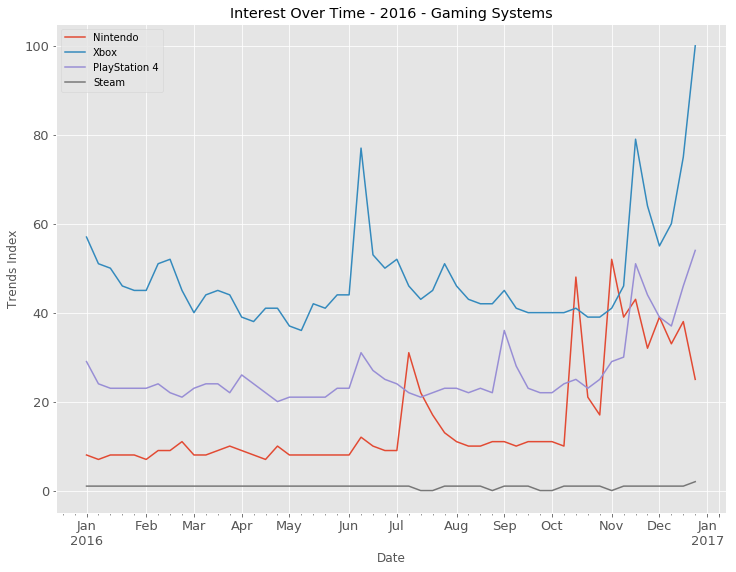

In [6]:
# Plotting interest over time
ax = df_iot.plot.line(figsize = (12,9), title = "Interest Over Time - 2016 - Gaming Systems")
ax.set_xlabel('Date')
ax.set_ylabel('Trends Index')
ax.tick_params(axis='both', which='major', labelsize=13)

In [17]:
# Example of hourly data
pytrend.build_payload(kw_list=['Nintendo'], geo = 'US', cat = 68, timeframe= "now 7-d")
daily = pytrend.interest_over_time()
daily.head()

,Nintendo,isPartial
date,,
2018-08-07 21:00:00,35,False
2018-08-07 22:00:00,31,False
2018-08-07 23:00:00,29,False
2018-08-08 00:00:00,32,False
2018-08-08 01:00:00,48,False


### Comparing to Total Category

Leaveing the keywords list with an empty string will return the total search volume for the given category. That cannot be compared to search terms directly, but we can analyze shape to see how a term has moved with the overall trends of an industry. 

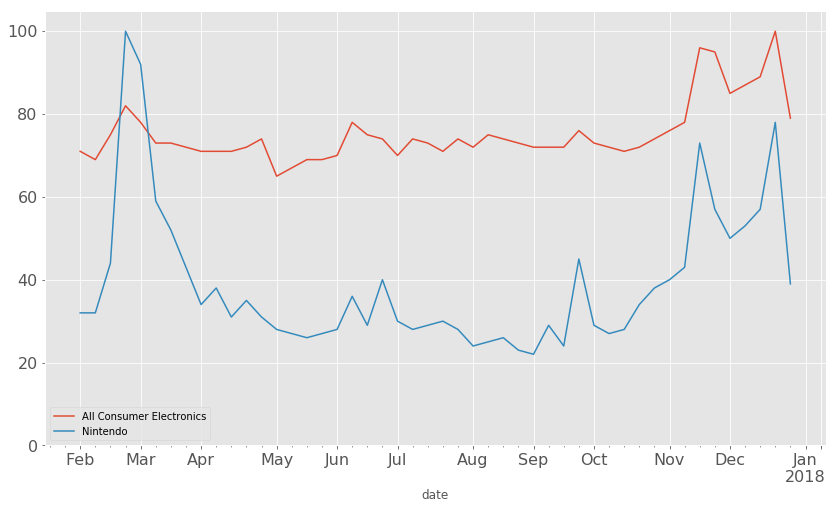

In [7]:
pytrend.build_payload(kw_list=[''], geo = 'US', cat = 78, timeframe= "2017-01-31 2017-12-31")
cat_total = pytrend.interest_over_time().drop('isPartial', axis = 1)
cat_total = cat_total.rename(columns = {"":"All Consumer Electronics"})
pytrend.build_payload(kw_list=['Nintendo'], geo = 'US', cat = 78, timeframe= "2017-01-31 2017-12-31")
nin_total = pytrend.interest_over_time().drop('isPartial', axis = 1)
both = pd.concat([cat_total, nin_total], axis = 1)
both.plot(figsize = (14,8), ylim =([0,105]), fontsize = 16)

In [23]:
both.corr()

,All Consumer Electronics,Nintendo
All Consumer Electronics,1.000000,0.686169
Nintendo,0.686169,1.000000


## interest_by_region()

The other primary method provided by pytrends is interest_by_region(). Once the payload is loaded appriately, calling this method with a given 'resolution' parameter will return a dataframe of indexed search popularity by region for the given payload characteristics.

Google trends provides no actual search volumes. Instead it indexes all searches into a 0-100 scale. For searches by geography, the total seach popularity is normalized by total searches in that region, then allocated to the search terms proportionally.

Resolution indicates the granularity of the search regions. "COUNTRY" is the default. 'CITY' returns city level data, 'COUNTRY' returns country level data, 'DMA' returns Metro level data (in the US, equivalent to Designated Market Area), 'REGION' returns Region level data.

In [24]:
# Example interest by region for 2016

pytrend.build_payload(kw_list=srch_refs, geo = 'US', cat = 78, timeframe= '2016-01-01 2016-12-31') 
interest_by_region_df = pytrend.interest_by_region(resolution='DMA')
interest_by_region_df = interest_by_region_df.rename(columns=dict(zip(srch_refs, srch_names)))
interest_by_region_df.tail(10)

,Nintendo,Xbox,PlayStation 4,Steam
geoName,,,,
West Palm Beach-Ft. Pierce FL,26,76,44,0
Wheeling WV-Steubenville OH,27,82,36,0
Wichita Falls TX & Lawton OK,19,88,39,0
Wichita-Hutchinson KS,23,83,39,0
Wilkes Barre-Scranton PA,25,79,42,0
Wilmington NC,22,88,36,0
Yakima-Pasco-Richland-Kennewick WA,22,86,38,0
Youngstown OH,23,86,36,0
Yuma AZ-El Centro CA,25,73,48,0


In [25]:
# Example to build out weekly geo compares for 5 search terms

start = dt.date(2017,1,1)
end = start + dt.timedelta(6)

#For 52 weeks, create a date string for the week, build the payload, pull the interest by region, rename columns from topic codes, and append to a master dataframe
for i in range(52):
    start_1 = start + dt.timedelta(i*7)
    end_1 = end + dt.timedelta(i*7)
    time_frame = str(start_1) + ' ' + str(end_1)
    pytrend.build_payload(kw_list=srch_refs, geo = 'US', cat = 68, timeframe= time_frame)
    ibr_df = pytrend.interest_by_region(resolution='DMA')
    ibr_df = ibr_df.rename(columns=dict(zip(srch_refs, srch_names)))
    ibr_df['Date'] = end_1
    if i == 0:
        ibr_df_master = ibr_df
    else:
        ibr_df_master = ibr_df_master.append(ibr_df)

ibr_df_master.shape

(10920, 5)

In [26]:
# Make the date the index and make it a datetimeIndex
ibr_df_master = ibr_df_master.reset_index()
ibr_df_master.set_index("Date", inplace=True)
ibr_df_master.index = pd.to_datetime(ibr_df_master.index)
ibr_df_master.head()

,geoName,Nintendo,Xbox,PlayStation 4,Steam
Date,,,,,
2017-01-07,Abilene-Sweetwater TX,0,0,0,100
2017-01-07,Albany GA,0,0,0,0
2017-01-07,Albany-Schenectady-Troy NY,0,0,0,0
2017-01-07,Albuquerque-Santa Fe NM,0,100,0,0
2017-01-07,Alexandria LA,0,0,0,0


In [132]:
#Write/Read
#ibr_df_master.to_csv("Output/" + str(start) + ' ' + str(end_1) + ".csv")
#ibr_df_master = pd.read_csv("Output\DMA_breakout_2016-01-01 2016-12-29.csv")

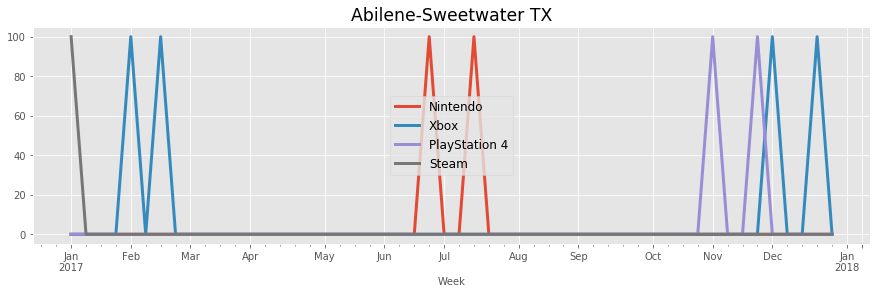

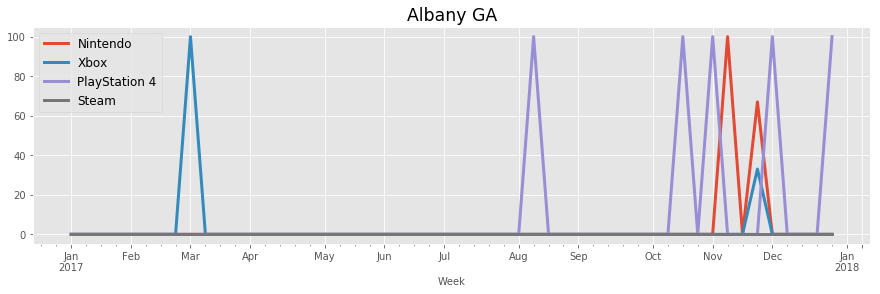

In [27]:
#Look at first 2 graphs by region

#Group on geoName
grps = ibr_df_master.groupby(['geoName'])

#For each group, plot the time series 
for i, (title, group) in enumerate(grps):
    if i < 2:
        group.plot(figsize=(15,4), linewidth=3, fontsize=10, title=title)
        plt.xlabel('Week', fontsize=10);


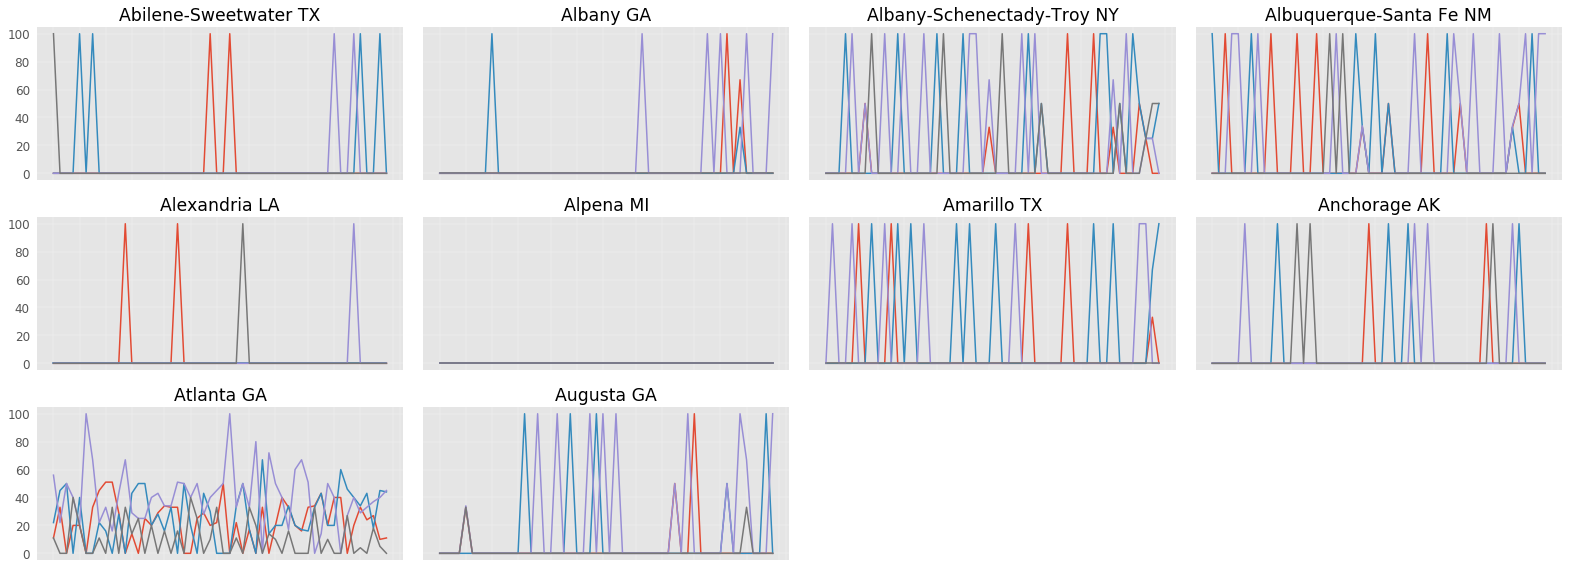

In [28]:
#Source: http://jonathansoma.com/lede/data-studio/classes/small-multiples/long-explanation-of-using-plt-subplots-to-create-small-multiples/
# Plotting first 10 regions in a subplot
fig, axes = plt.subplots(nrows=53, ncols=4, sharex=True, sharey=True, figsize=(22,140))
axes_list = [item for sublist in axes for item in sublist] 

for i, (title, group) in enumerate(grps):
    if i < 10:
        ax = axes_list.pop(0)
        group.plot(label=title, ax=ax, legend=False, clip_on=False)
        ax.set_title(title)
        ax.tick_params(
            which='both',
            bottom='off',
            left='off',
            right='off',
            top='off'
        )
        ax.grid(linewidth=0.25)
        ax.set_xlabel("")
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

for ax in axes_list:
    ax.remove()

plt.tight_layout()

### Looking at regions with largest population

In [30]:
# Pull in DMA populations from https://www.lyonspr.com/latest-nielsen-dma-rankings/
dma_stats = pd.read_excel('DMA_Stats.xlsx',skiprows=4)
print(dma_stats.shape)
dma_stats.head()

(210, 4)


,Rank,Designated Market Area (DMA),TV Homes,% of US
0,1,New York,7348620,6.407
1,2,Los Angeles,5476830,4.775
2,3,Chicago,3463060,3.019
3,4,Philadelphia,2942800,2.566
4,5,Dallas-Ft. Worth,2713380,2.366


In [31]:
# Check the Google Trends list versus the source list for equivalence in order to map them together
list1 = sorted(dma_stats['Designated Market Area (DMA)'].values)
list2 = list(grps.groups.keys())
[(i,j) for i, j in zip(list1, list2)]

[('Abilene-Sweetwater', 'Abilene-Sweetwater TX'),
 ('Albany, GA', 'Albany GA'),
 ('Albany-Schenectady-Troy', 'Albany-Schenectady-Troy NY'),
 ('Albuquerque-Santa Fe', 'Albuquerque-Santa Fe NM'),
 ('Alexandria, LA', 'Alexandria LA'),
 ('Alpena', 'Alpena MI'),
 ('Amarillo', 'Amarillo TX'),
 ('Anchorage', 'Anchorage AK'),
 ('Atlanta', 'Atlanta GA'),
 ('Augusta-Aiken', 'Augusta GA'),
 ('Austin', 'Austin TX'),
 ('Bakersfield', 'Bakersfield CA'),
 ('Baltimore', 'Baltimore MD'),
 ('Bangor', 'Bangor ME'),
 ('Baton Rouge', 'Baton Rouge LA'),
 ('Beaumont-Port Arthur', 'Beaumont-Port Arthur TX'),
 ('Bend, OR', 'Bend OR'),
 ('Billings', 'Billings, MT'),
 ('Biloxi-Gulfport', 'Biloxi-Gulfport MS'),
 ('Binghamton', 'Binghamton NY'),
 ('Birmingham (Ann and Tusc)', 'Birmingham AL'),
 ('Bluefield-Beckley-Oak Hill', 'Bluefield-Beckley-Oak Hill WV'),
 ('Boise', 'Boise ID'),
 ('Boston (Manchester)', 'Boston MA-Manchester NH'),
 ('Bowling Green', 'Bowling Green KY'),
 ('Buffalo', 'Buffalo NY'),
 ('Burlington

In [32]:
# Map names in dma_stats table to map Google Trends region
mapping = dict(zip(list1, list2))
dma_stats['Designated Market Area (DMA)'].replace(mapping, inplace = True)
dma_stats.head(5)


,Rank,Designated Market Area (DMA),TV Homes,% of US
0,1,New York NY,7348620,6.407
1,2,Little Rock-Pine Bluff AR,5476830,4.775
2,3,Chicago IL,3463060,3.019
3,4,Philadelphia PA,2942800,2.566
4,5,Dallas-Ft. Worth TX,2713380,2.366


In [33]:
# Get the order to sort the DMAs in
sort_order = dma_stats['Designated Market Area (DMA)'].values


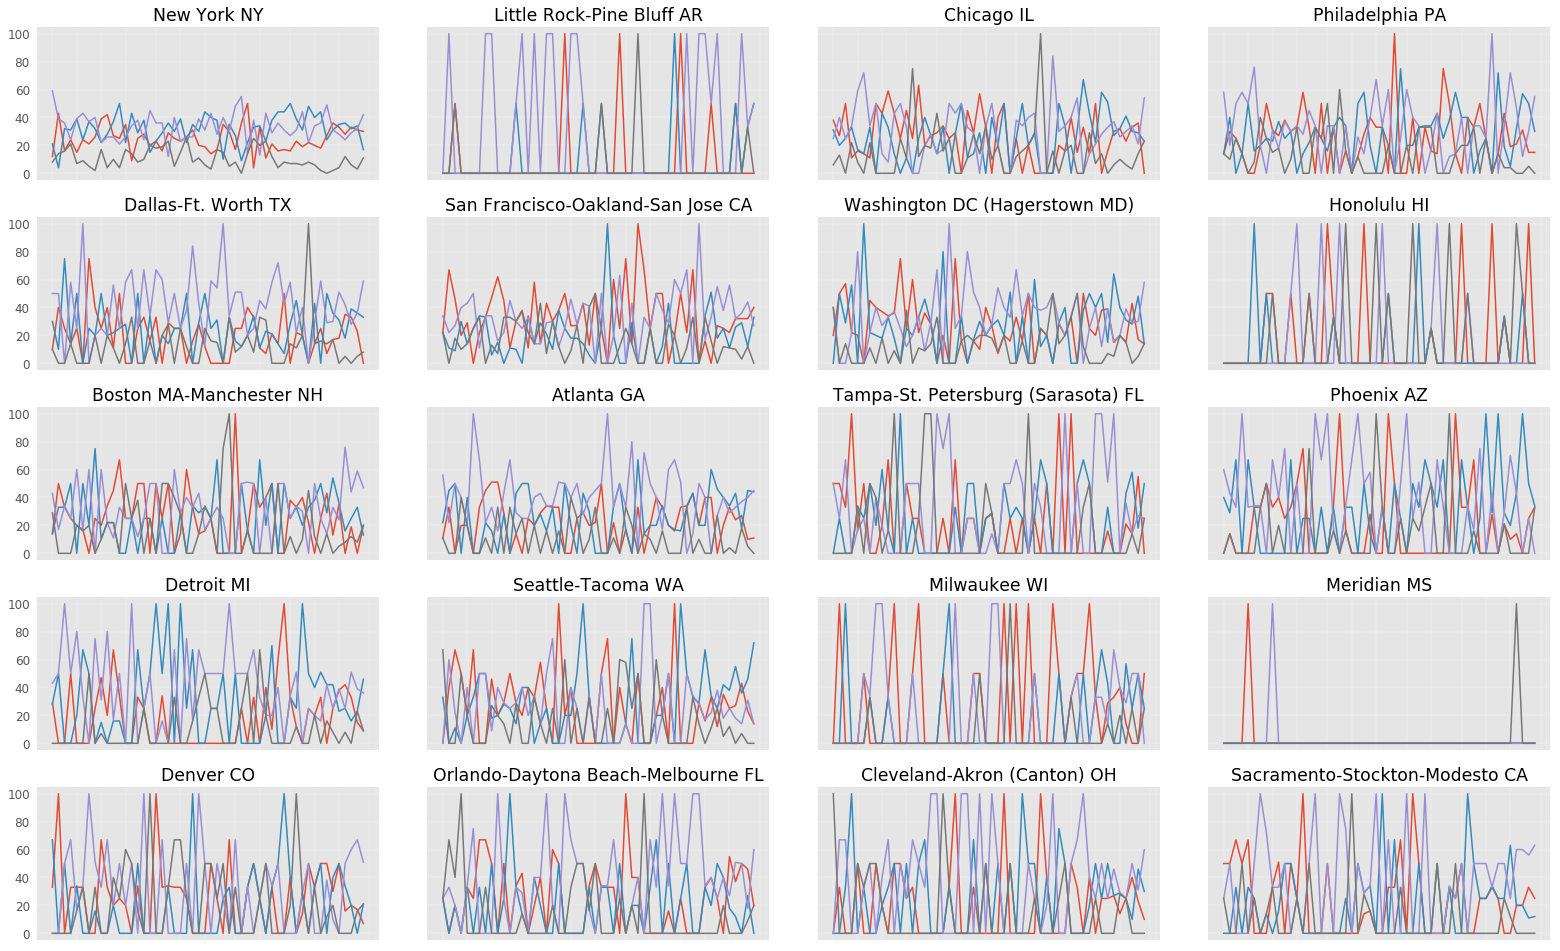

In [34]:
#Source: http://jonathansoma.com/lede/data-studio/classes/small-multiples/long-explanation-of-using-plt-subplots-to-create-small-multiples/

fig, axes = plt.subplots(nrows=53, ncols=4, sharex=True, sharey=True, figsize=(22,140))
axes_list = [item for sublist in axes for item in sublist] 

# Graph the over time comparison of the 5 competitors by top 20 regions
for i, region in enumerate(sort_order):
    if i < 20:
        selection = grps.get_group(region)

        ax = axes_list.pop(0)
        selection.plot(ax=ax, legend=False, clip_on=False, fontsize = 12)
        ax.set_title(region)
        ax.tick_params(
            which='both',
            bottom='off',
            left='off',
            right='off',
            top='off'
        )
        ax.grid(linewidth=0.25)
        ax.set_xlabel("")
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

# Now use the matplotlib .remove() method to 
# delete anything we didn't use
for ax in axes_list:
    ax.remove()

plt.tight_layout()

## related_queries()

The related_queries() function pulls is all suggested query information that would generally fill in the related queries area of the google trends search. This highlights search terms the are grouped together or near in meaning with high search volume or high growth in search volume.

The related_queries() function returns a dictionary of dictionaries of dataframes. The outer dictionary holds the search term, the inner has a key of a 'top' or 'rising', each corresponding to a dataframe of top or rising searches. 

In [35]:
# Run related queries

srch_terms =['Nintendo', 'Xbox','Playstation','Steam']

pytrend.build_payload(kw_list=srch_terms, geo = 'US', cat = 78, timeframe= 'today 3-m')
related_queries_dict = pytrend.related_queries()
print(related_queries_dict)

{'Nintendo': {'top':                           query  value
0               switch nintendo    100
1                nintendo games     23
2                  switch games     15
3         nintendo switch games     14
4                   nintendo ds     12
5              classic nintendo     10
6                super nintendo     10
7           nintendo controller      8
8                 nintendo game      7
9                   nintendo 64      7
10                 nintendo nes      6
11   nintendo switch controller      5
12                 nintendo wii      5
13     nintendo switch fortnite      5
14                 nintendo 3ds      4
15                nintendo news      4
16                nintendo roms      3
17          the nintendo switch      3
18         nintendo nes classic      3
19                 new nintendo      3
20              nintendo reddit      3
21             nintendo ds roms      3
22              nintendo direct      3
23  nintendo classic controller      1
24  

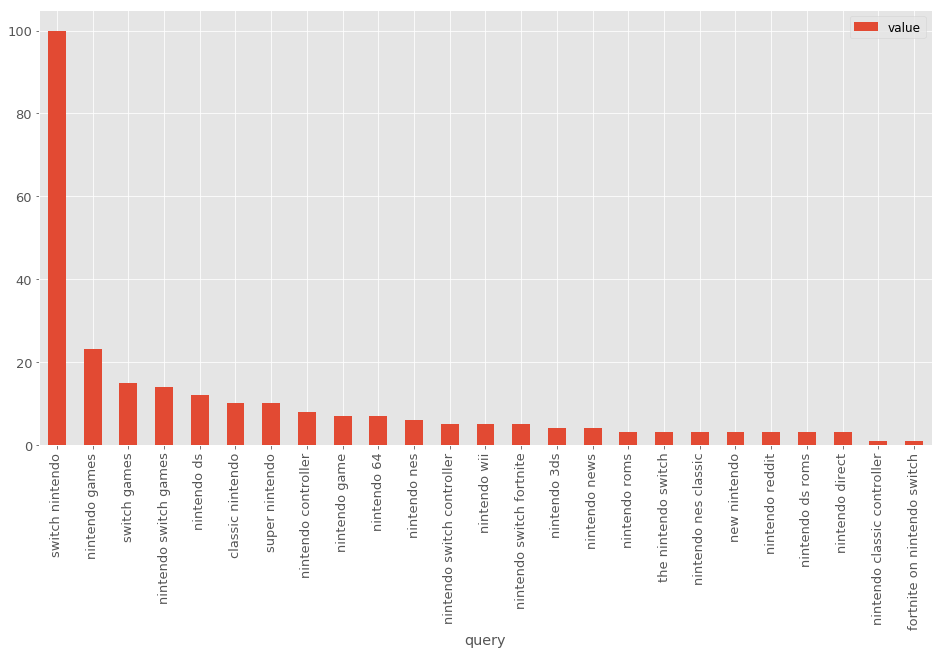

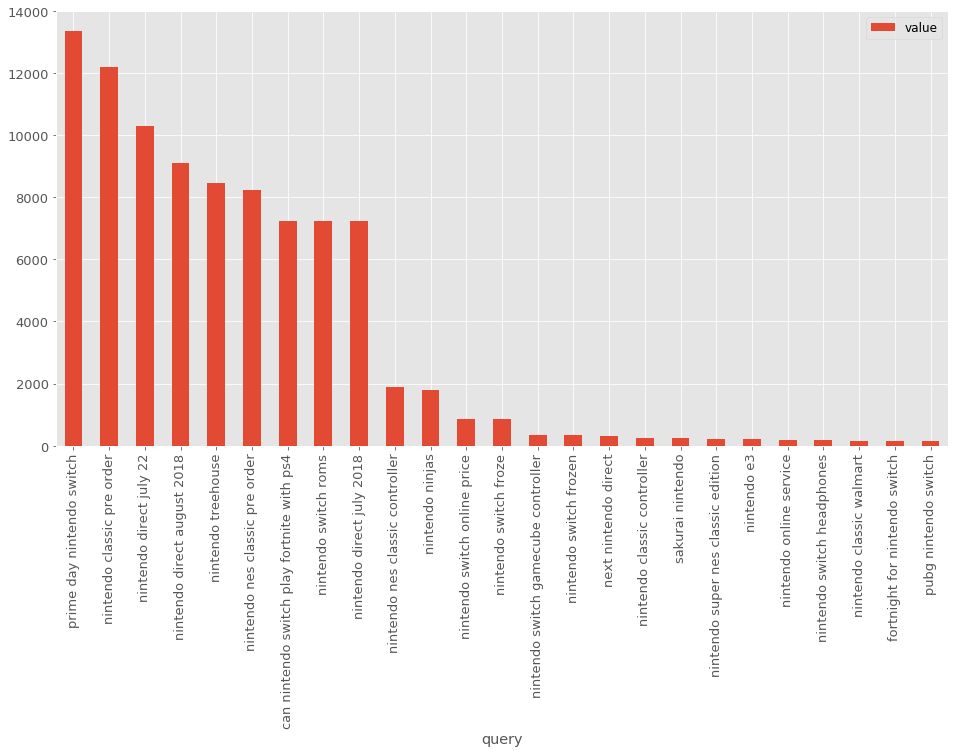

In [36]:
# Graph top and rising for Nintendo
related_queries_dict.get('Nintendo').get('top').plot(figsize = (16,8), kind = 'bar', x = 'query', fontsize = 13)
related_queries_dict.get('Nintendo').get('rising').plot(figsize = (16,8), kind = 'bar', x = 'query', fontsize = 13)